
# Task 2 — Change Point Modeling & Insight Generation (Exhaustive)

This notebook follows the **recommended, section-by-section** workflow:
1. **Data Preparation & EDA** (brief recap for independence)
2. **Bayesian Change Point Model (PyMC3 & PyMC)** — code provided for both
3. **Sampling & Convergence Checks** (r-hat, trace plots)
4. **Identify Change Points** — posterior for τ, MAP date, HPD range
5. **Associate Changes with Causes** — match τ to events (±90 days, nearest)
6. **Quantify the Impact** — pre/post means in **prices** and **returns**, volatility change
7. **Save Artifacts** — figures, JSON/CSV, human-readable summary
8. **Advanced Extensions (Optional)** — future work ideas


## 0. Paths & Imports

In [1]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, arviz as az
from pathlib import Path

import sys
from pathlib import Path
root_path = str(Path("..").resolve())
if root_path not in sys.path:
    sys.path.insert(0, root_path)
print("Added to sys.path:", root_path)
from modeling.utils_changepoint import compute_returns, summarize_impact, nearest_events, events_within_window

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 110

PRICE_PATH = Path("../data/BrentOilPrices.csv")
EVENTS_PATH = Path("../data/events_compiled.csv")
OUT_DIR = Path("../modeling/results"); OUT_DIR.mkdir(parents=True, exist_ok=True)


Added to sys.path: /Users/mebsahle/Documents/10x/week10/bayesian_time_series_regime_change_analysis


## 1. Data Preparation & Quick EDA

,Price,log_ret
count,8359.000000,8359.000000
mean,46.462998,-0.000085
std,32.505190,0.024876
min,9.100000,-0.643699
25%,18.780000,-0.011153
50%,31.770000,0.000089
75%,67.045000,0.011786
max,143.950000,0.301613


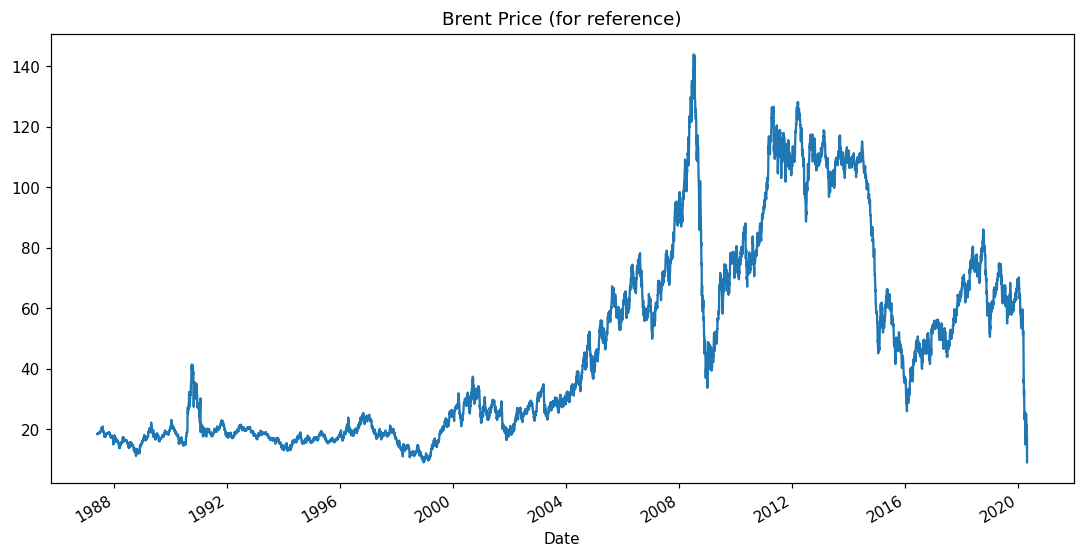

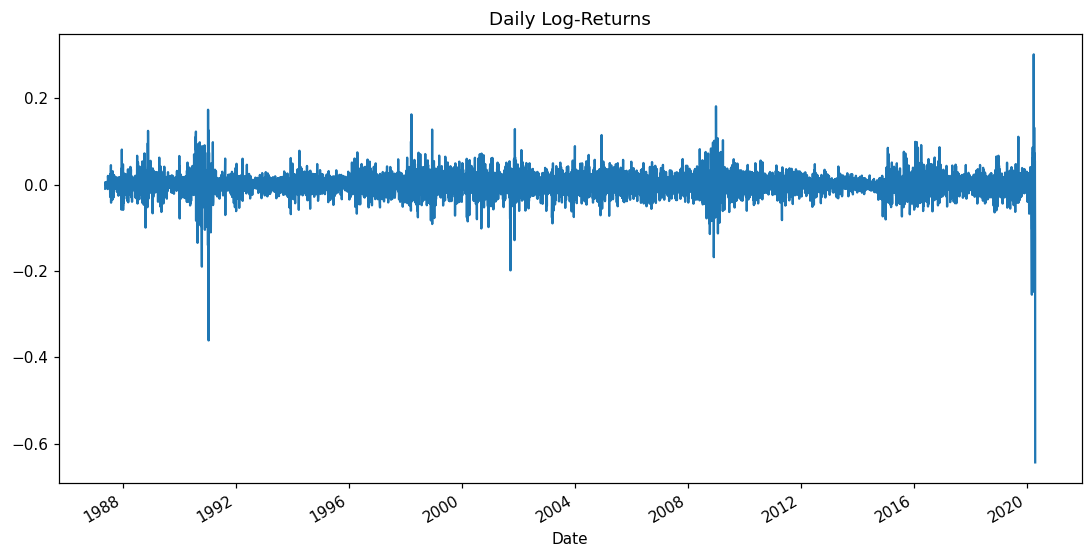

In [2]:

# Load raw prices (supports 20-May-87)
df = pd.read_csv(PRICE_PATH)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y', errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date').drop_duplicates(subset=['Date']).set_index('Date')

# Returns
df = compute_returns(df)

# Minimal EDA
display(df[['Price','log_ret']].describe())
ax = df['Price'].plot(title='Brent Price (for reference)'); plt.show()
ax = df['log_ret'].plot(title='Daily Log-Returns'); plt.show()


## 2. Model Definition


### 2.1 PyMC3 version (if you prefer strict PyMC3)

> Requires `pymc3` (legacy) and `arviz`:
> ```bash
> pip install pymc3 arviz
> ```


In [3]:

# PyMC3 variant (commented by default). Uncomment to use PyMC3.
# import pymc3 as pm
# y = df['log_ret'].dropna()
# y_std = (y - y.mean())/y.std(ddof=0)
# n = len(y_std); idx = np.arange(n)
#
# with pm.Model() as model3:
#     tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)
#     mu1 = pm.Normal('mu1', mu=0, sd=1)
#     mu2 = pm.Normal('mu2', mu=0, sd=1)
#     sigma1 = pm.HalfNormal('sigma1', sd=1.0)
#     sigma2 = pm.HalfNormal('sigma2', sd=1.0)
#     mu = pm.math.switch(idx < tau, mu1, mu2)
#     sigma = pm.math.switch(idx < tau, sigma1, sigma2)
#     obs = pm.Normal('obs', mu=mu, sd=sigma, observed=y_std.values)
#     trace3 = pm.sample(1500, tune=1000, chains=4, random_seed=42, return_inferencedata=True, target_accept=0.9)



### 2.2 PyMC (v4/v5) version (recommended, Student-T likelihood)
> ```bash
> pip install pymc arviz
> ```


In [4]:

import pymc as pm

y = df['log_ret'].dropna()
y_std = (y - y.mean())/y.std(ddof=0)
n = len(y_std); idx = np.arange(n)

with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)
    mu1 = pm.Normal('mu1', 0, 1)
    mu2 = pm.Normal('mu2', 0, 1)
    sigma1 = pm.HalfNormal('sigma1', 1.0)
    sigma2 = pm.HalfNormal('sigma2', 1.0)
    nu = pm.Exponential('nu', 1/30) + 2  # heavy tails
    mu = pm.math.switch(idx < tau, mu1, mu2)
    sigma = pm.math.switch(idx < tau, sigma1, sigma2)
    obs = pm.StudentT('obs', nu=nu, mu=mu, sigma=sigma, observed=y_std.values)


## 3. Sampling & Convergence Checks

In [5]:
# Sample the model
print("🔄 Starting MCMC sampling...")
print("=" * 50)

with model:
    idata = pm.sample(
        1500, 
        tune=1000, 
        chains=4, 
        target_accept=0.9, 
        random_seed=42, 
        idata_kwargs={'log_likelihood': True}
    )
    
print("\n✅ MCMC sampling completed!")
print("=" * 50)

# Sample posterior predictive
print("\n🎯 Generating posterior predictive samples...")
with model:
    ppc = pm.sample_posterior_predictive(idata, random_seed=42)

print("✅ Posterior predictive sampling completed!")
print("=" * 50)

# Convergence diagnostics
print("\n📊 CONVERGENCE DIAGNOSTICS")
print("=" * 50)

az_summary = az.summary(idata, var_names=['tau', 'mu1', 'mu2', 'sigma1', 'sigma2'])
display(az_summary)

print("\n📝 Convergence Check:")
print("- All r_hat values should be close to 1.0 (< 1.01 is excellent)")
print("- ESS (effective sample size) should be > 400 for reliable inference")
print("=" * 50)

🔄 Starting MCMC sampling...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2, nu]


/Users/mebsahle/Documents/10x/week10/bayesian_time_series_regime_change_analysis/.venv/lib/python3.13/site-packages
/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [obs]


/Users/mebsahle/Documents/10x/week10/bayesian_time_series_regime_change_analysis/.venv/lib/python3.13/site-packages
/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


✅ MCMC sampling completed!

🎯 Generating posterior predictive samples...


✅ Posterior predictive sampling completed!

📊 CONVERGENCE DIAGNOSTICS


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,4973.251,1583.805,2191.000,5947.000,789.472,455.435,7.0,41.0,1.53
mu1,0.022,0.012,-0.002,0.043,0.002,0.001,50.0,68.0,1.05
mu2,0.006,0.014,-0.021,0.033,0.003,0.000,19.0,185.0,1.14
sigma1,0.617,0.055,0.512,0.668,0.027,0.015,7.0,28.0,1.53
sigma2,0.580,0.047,0.533,0.671,0.023,0.013,7.0,28.0,1.53



📝 Convergence Check:
- All r_hat values should be close to 1.0 (< 1.01 is excellent)
- ESS (effective sample size) should be > 400 for reliable inference


📈 Generating Trace Plots...


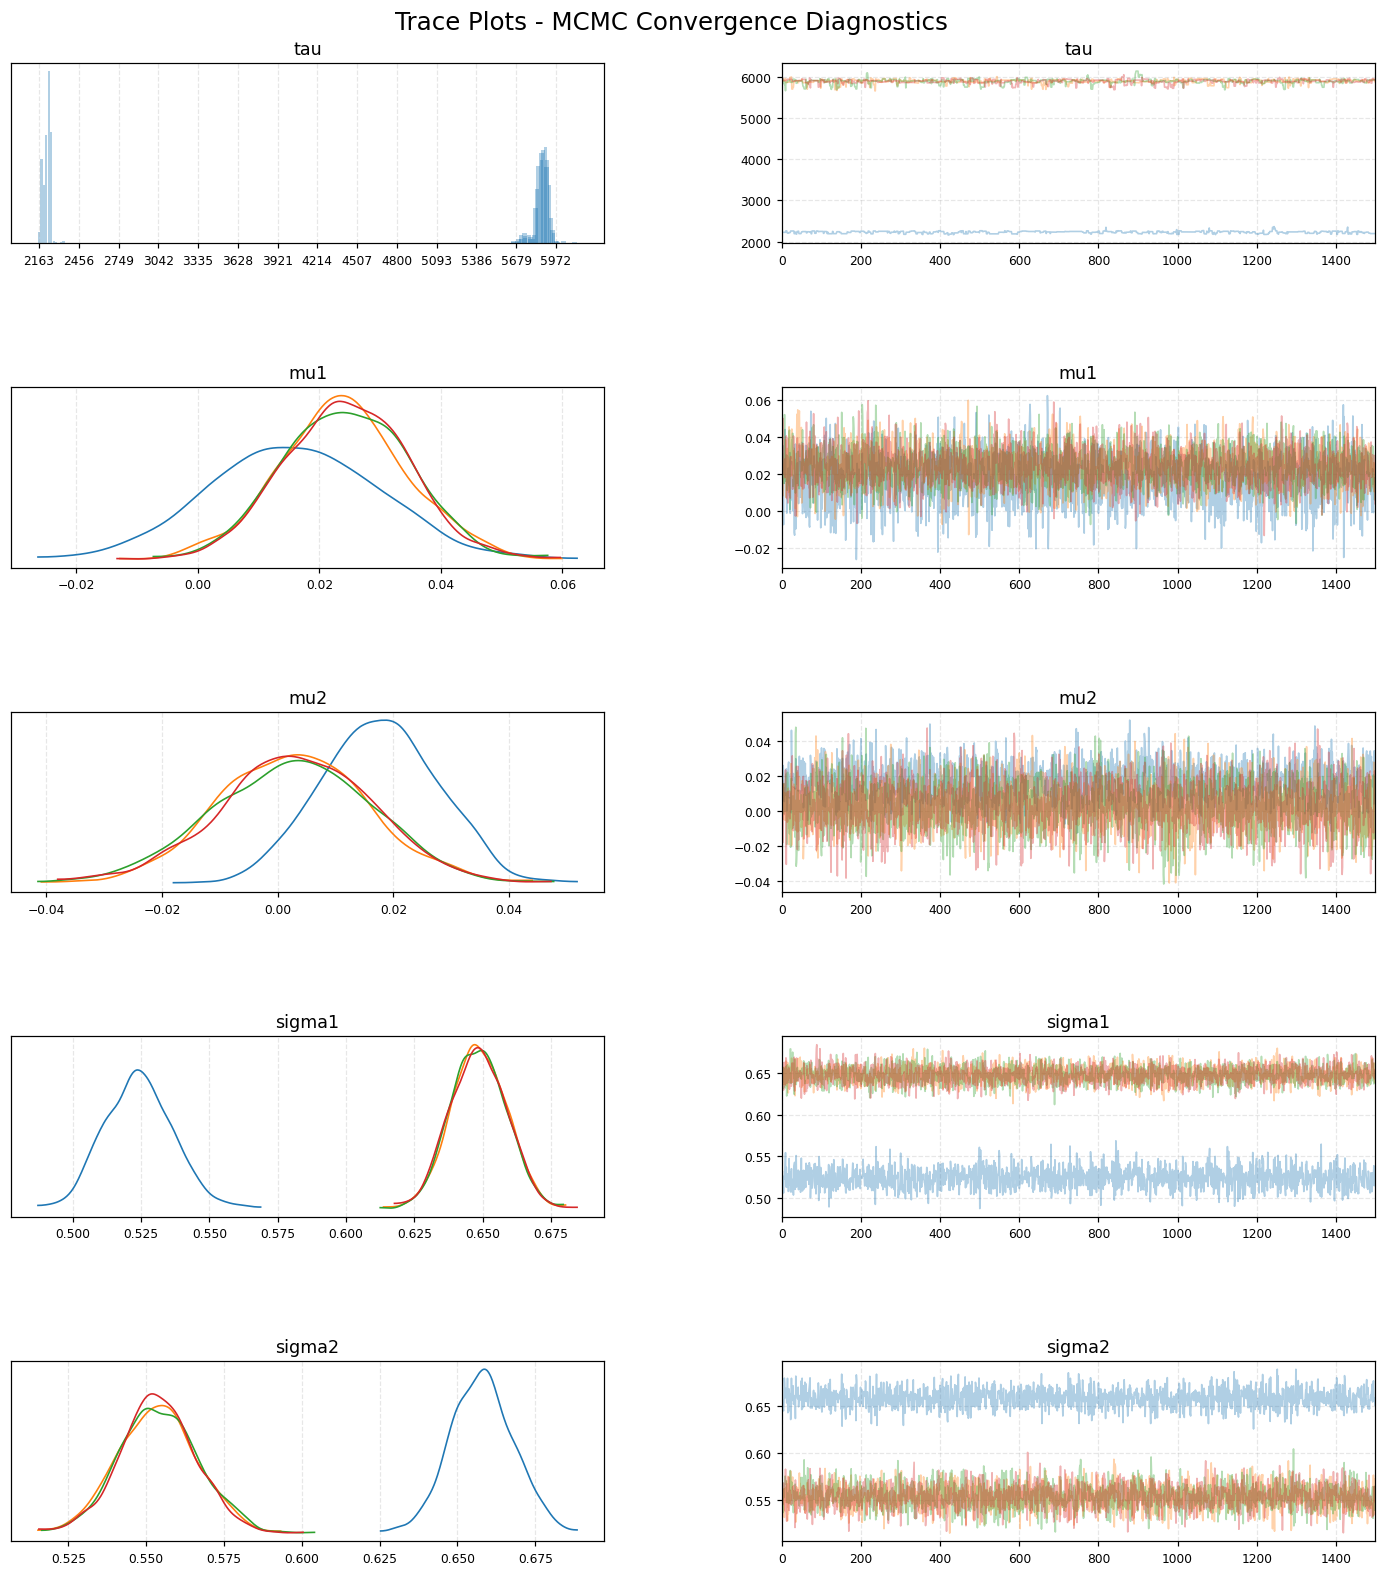

✅ Trace plots saved!
📊 Generating Posterior Density Plots...


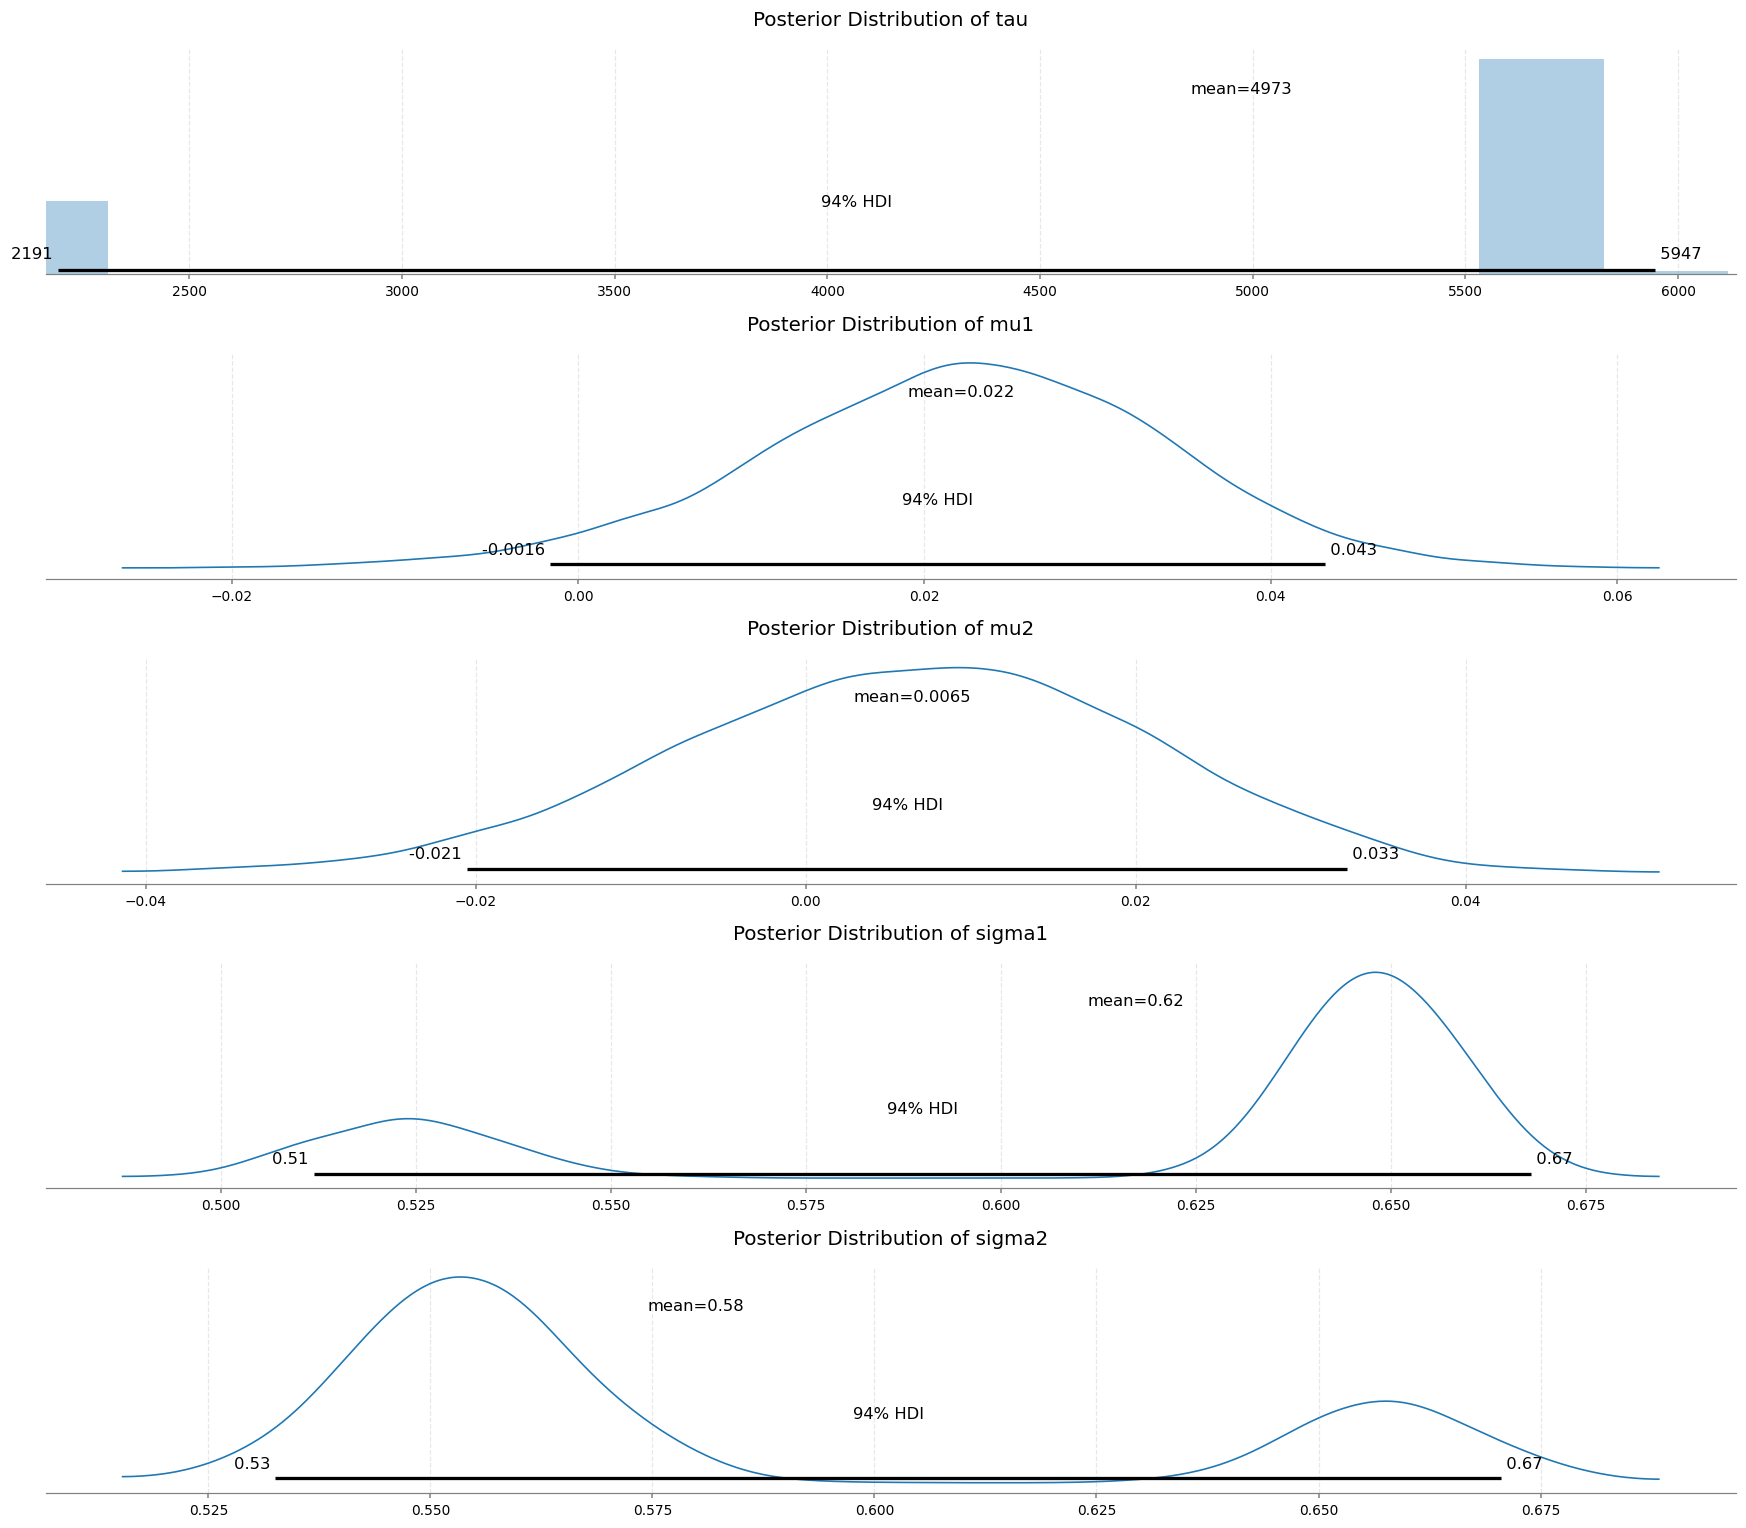

✅ Posterior density plots saved!


In [6]:
# Spacious, one-per-row visuals with improved formatting
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

vars_ = ['tau','mu1','mu2','sigma1','sigma2']

# 1) TRACE PLOTS — one variable per row with better spacing
print("📈 Generating Trace Plots...")
axes = az.plot_trace(
    idata, var_names=vars_, compact=False,
    figsize=(16, 3.2 * len(vars_))  # wider and taller for better spacing
)

# Improve formatting for each subplot
# axes is a 2D array: axes[variable_index, plot_type_index]
for i in range(len(vars_)):
    for j in range(2):  # trace plot has 2 columns (trace + histogram)
        ax = axes[i, j]
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='x', rotation=0)
        ax.grid(True, alpha=0.3, linestyle='--')

plt.subplots_adjust(top=0.95, hspace=0.8, wspace=0.3)
plt.suptitle("Trace Plots - MCMC Convergence Diagnostics", y=0.98, fontsize=16)
plt.savefig(OUT_DIR / 'trace_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Trace plots saved!")
print("=" * 50)

# 2) POSTERIOR DENSITIES — one variable per row with improved formatting  
print("📊 Generating Posterior Density Plots...")
fig, axes = plt.subplots(len(vars_), 1, figsize=(16, 2.8 * len(vars_)))

for ax, v in zip(np.atleast_1d(axes), vars_):
    az.plot_posterior(idata, var_names=[v], ax=ax, textsize=10)
    ax.set_title(f"Posterior Distribution of {v}", fontsize=13, pad=15)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.savefig(OUT_DIR / 'posterior_densities.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Posterior density plots saved!")
print("=" * 50)


## 4. Identify the Change Point

τ_MAP index: 5897 → date: 2010-08-04
94% HPD index range: 2177 6135
94% HPD date range: 1995-12-04 to 2011-07-18


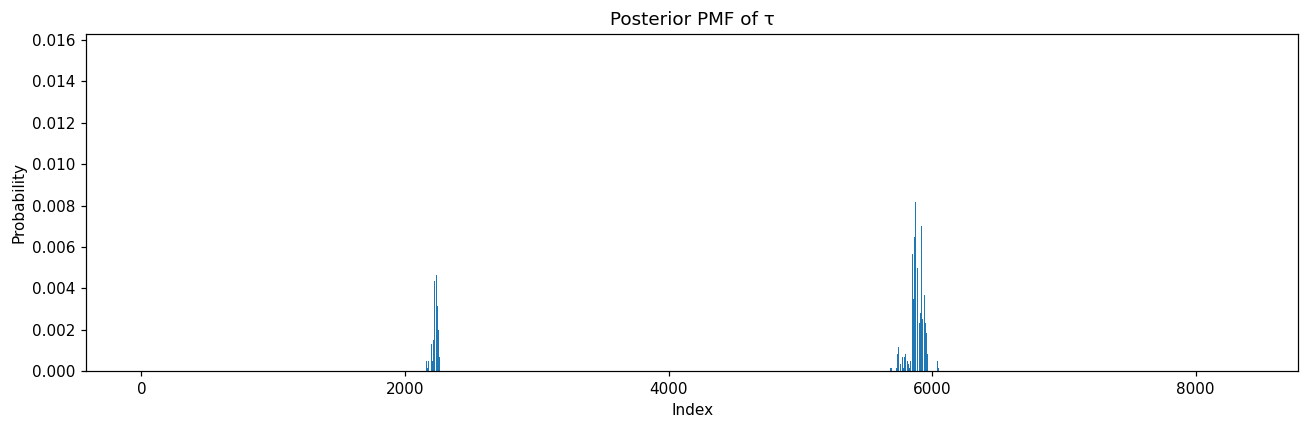

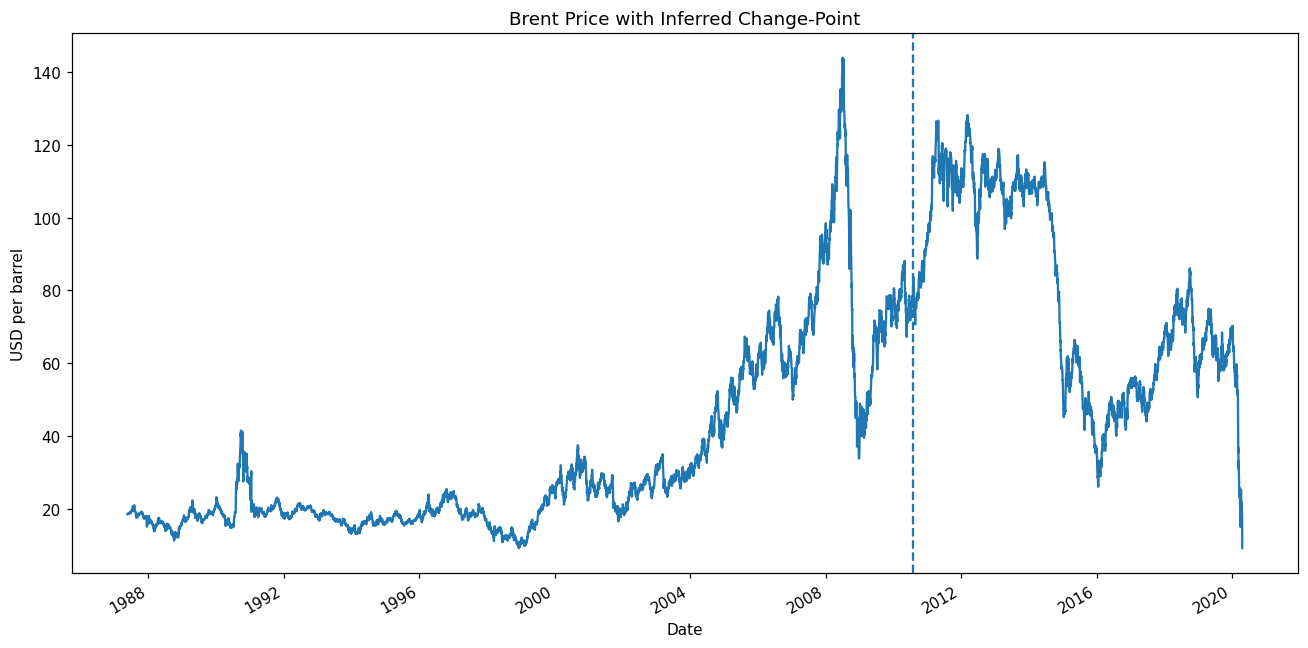

In [7]:

tau_samples = idata.posterior['tau'].values.ravel().astype(int)
pmf = np.bincount(tau_samples, minlength=n) / tau_samples.size
tau_map = int(pmf.argmax())

# Discrete 94% HPD for tau
order = np.argsort(pmf)[::-1]
accum = 0.0; keep = np.zeros_like(pmf, dtype=bool)
for i in order:
    keep[i] = True; accum += pmf[i]
    if accum >= 0.94: break
hpd_idxs = np.where(keep)[0]

print('τ_MAP index:', tau_map, '→ date:', df.index[tau_map].date())
print('94% HPD index range:', hpd_idxs.min(), hpd_idxs.max())
print('94% HPD date range:', df.index[hpd_idxs.min()].date(), 'to', df.index[hpd_idxs.max()].date())

# Plot PMF
plt.figure(figsize=(12,4))
plt.bar(np.arange(n), pmf)
plt.title('Posterior PMF of τ')
plt.xlabel('Index'); plt.ylabel('Probability')
plt.tight_layout(); plt.savefig(OUT_DIR / 'tau_posterior_pmf.png', bbox_inches='tight'); plt.show()

# Price + τ
plt.figure(figsize=(12,6))
df['Price'].plot()
plt.axvline(df.index[tau_map], linestyle='--')
plt.title('Brent Price with Inferred Change-Point')
plt.xlabel('Date'); plt.ylabel('USD per barrel')
plt.tight_layout(); plt.savefig(OUT_DIR / 'price_with_tau.png', bbox_inches='tight'); plt.show()


## 5. Associate Changes with Causes (Events)

In [8]:

events = pd.read_csv(EVENTS_PATH, parse_dates=['start_date']).sort_values('start_date')
tau_date = df.index[tau_map]

nearest = nearest_events(tau_date, events, k=5)
nearby_90 = events_within_window(tau_date, events, window_days=90)

display(nearest)
display(nearby_90)
nearest.to_csv(OUT_DIR / 'nearest_events.csv', index=False)
nearby_90.to_csv(OUT_DIR / 'nearby_events_90d.csv', index=False)


,event,start_date,type,region,source_url,notes,gap_days
8,Libyan Civil War unrest and supply disruption,2011-02-15,geopolitical,North Africa,https://www.britannica.com/event/Libya-Revolt-...,Output collapse; EIA estimated 60–90% drop in ...,195
7,BP Prudhoe Bay partial shutdown (pipeline corr...,2006-08-06,infrastructure,U.S. Alaska,https://www.everycrsreport.com/reports/RL33629...,Partial field shutdown due to severe corrosion.,1459
9,OPEC opts not to cut production,2014-11-27,OPEC policy,Vienna,https://www.reuters.com/article/business/saudi...,Decision accelerates 2014–2016 oil price slump.,1576
6,Hurricane Katrina landfall; Gulf energy disrup...,2005-08-29,weather/infrastructure,U.S. Gulf of Mexico,https://www.everycrsreport.com/reports/RL33124...,Large shut-ins of GOM production and refining.,1801
10,U.S. lifts 40-year crude export ban,2015-12-18,policy,United States,https://www.eia.gov/dnav/pet/pet_move_exp_dc_n...,Legislation authorizes crude exports without l...,1962


,event,start_date,type,region,source_url,notes


## 6. Quantify the Impact

In [9]:

# Global and local (±30d) impact
imp_global = summarize_impact(df, tau_map, window_days=None)
imp_local = summarize_impact(df, tau_map, window_days=30)

from dataclasses import asdict
import json

json.dump(asdict(imp_global), open(OUT_DIR / 'impact_global.json','w'), indent=2, default=str)
json.dump(asdict(imp_local), open(OUT_DIR / 'impact_local_±30d.json','w'), indent=2, default=str)

imp_global, imp_local


(ImpactSummary(tau_index=5897, tau_date='2010-08-04', pre_price_mean=33.12957266406647, post_price_mean=78.39931356620633, price_pct_change=136.64450598616096, pre_ret_mean=0.00025458204773226394, post_ret_mean=-0.0008999080893600385, ret_mean_diff=-0.0011544901370923026, pre_ret_std=0.023929284132983352, post_ret_std=0.02699572870534756),
 ImpactSummary(tau_index=5897, tau_date='2010-08-04', pre_price_mean=76.95409090909091, post_price_mean=76.29695652173913, price_pct_change=-0.8539304143402527, pre_ret_mean=0.007034895996479575, post_ret_mean=-0.004702412457957315, ret_mean_diff=-0.01173730845443689, pre_ret_std=0.01855715316678044, post_ret_std=0.01866471607447633))

### 6.1 Probabilistic Statement: P(μ₂ > μ₁)

In [10]:

# Probability that post-change mean (standardized returns) exceeds pre-change mean
p_mu2_gt_mu1 = float((idata.posterior['mu2'] > idata.posterior['mu1']).mean().values)
print(f"P(mu2 > mu1) ≈ {p_mu2_gt_mu1:.3f}")


P(mu2 > mu1) ≈ 0.215


## 7. Save Artifacts

In [12]:
az.to_netcdf(idata, OUT_DIR / 'task2_trace.nc')
az.summary(idata, var_names=['tau','mu1','mu2','sigma1','sigma2']).to_csv(OUT_DIR / 'task2_summary.csv')

# Posterior predictive quick stats (standardized)
y_sim = ppc.posterior_predictive['obs'].stack(sample=('chain','draw')).values
ppc_stats = {
    "mean": float(np.mean(y_sim)),
    "std": float(np.std(y_sim)),
    "q05": float(np.quantile(y_sim, 0.05)),
    "q95": float(np.quantile(y_sim, 0.95)),
    "n_samples": int(y_sim.size)
}

# Save PPC stats
json.dump(ppc_stats, open(OUT_DIR / 'posterior_predictive_stats.json','w'), indent=2)
print("✅ Posterior predictive stats saved to posterior_predictive_stats.json")

print("\n📋 POSTERIOR PREDICTIVE SUMMARY:")
print(f"  Mean: {ppc_stats['mean']:.4f}")
print(f"  Std:  {ppc_stats['std']:.4f}")
print(f"  5%:   {ppc_stats['q05']:.4f}")
print(f"  95%:  {ppc_stats['q95']:.4f}")
print(f"  Samples: {ppc_stats['n_samples']:,}")

print("\n" + "=" * 50)
print("✅ All artifacts saved to:", OUT_DIR)

ppc_stats


✅ Posterior predictive stats saved to posterior_predictive_stats.json

📋 POSTERIOR PREDICTIVE SUMMARY:
  Mean: 0.0176
  Std:  0.9661
  5%:   -1.3749
  95%:  1.4121
  Samples: 50,154,000

✅ All artifacts saved to: ../modeling/results


{'mean': 0.01760332148331223,
 'std': 0.9661314817907797,
 'q05': -1.3749468154020976,
 'q95': 1.4120531312956555,
 'n_samples': 50154000}


## 8. Advanced Extensions (Optional)
- **Additional factors**: Add regressors (e.g., USD index, global PMI) via a regression term in the likelihood.
- **Multiple change points**: Extend the model (e.g., hierarchical priors on multiple τ's or product partition models).
- **Markov-Switching**: Explicit calm vs. volatile regimes with state transition probabilities.
- **VAR**: Joint dynamics of oil price and macro variables to study impulse responses.
